**# Ejemplo de Árbol de decisión**

In [570]:
######################
# adquirir datos
######################

import pandas as pd
datos_raw = pd.read_csv("data/diabetes.csv") # dataframe


## Pre-procesamiento de datos

### Indagacion

In [571]:
# Indagacion de los datos
# Analizo los datos en busca de ceros y faltantes

# Voy a categorizar en funcion de los casos sin diabetes (casos negativos)
casos_negativos = datos_raw.sort_values(by='Outcome')
cantidad_casos_negativos = casos_negativos['Outcome'].value_counts(sort=False,ascending=True)[0]
casos_negativos = casos_negativos[:cantidad_casos_negativos]
# print(casos_negativos)

import numpy as np
caracteristicas = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI','DiabetesPedigreeFunction']
cuenta = 0
for caract in caracteristicas:
    descriptor = datos_raw[caract].describe()
    cuenta_de_valores = datos_raw[caract].value_counts()
    cantidad_ceros = cuenta_de_valores[0] if 0 in cuenta_de_valores else 0
    cuenta += cantidad_ceros
    print(f'cantidad de ceros en {caract}: {cantidad_ceros}')
print(f'cuenta:{cuenta}')



cantidad de ceros en Glucose: 5
cantidad de ceros en BloodPressure: 35
cantidad de ceros en SkinThickness: 227
cantidad de ceros en Insulin: 374
cantidad de ceros en BMI: 11
cantidad de ceros en DiabetesPedigreeFunction: 0
cuenta:652


### Tratamiento de nulos

Dado que existe una cantidad significativa de ceros, y considerando que 
representan una variable no medida, los paso a NaN para que no sean considerados 
en los promedios y otros calculos

In [572]:
# Asumo que los valores nulos de `caracteristicas` no fueron medidos y los convierto a NaN

# print(datos['Glucose'].describe())
for caract in caracteristicas:
    descriptor = casos_negativos[caract].describe()
    datos_raw[caract] = datos_raw[caract].replace([0, 0.0], np.NaN)
    casos_negativos[caract] = casos_negativos[caract].replace([0, 0.0, '0'], np.NaN)
# print(datos['Glucose'].describe())

Se decide avanzar eliminando las filas con datos faltantes

In [573]:
# Se prueba eliminando todas las filas que contengan algun NaN
datos_segun_media = datos_raw.dropna().reset_index()
datos_segun_cuantiles = datos_segun_media.copy()
# print(datos_segun_cuantiles)

### Categorización de características

#### Criterios usados

Se generaran las categorías según dos criterios y luego se evaluará sus resultados.

1. Según media: se generan 3 intervalos en función de la media +- la desviación estandar. La media se toma sólo de los casos de personas no diabéticas, para que las etiquetas representen los valores de gente sana. Los intervalos configuran las categorías 0, 1 y 2 que representarían valores "bajo", "medio" y "alto".

2. Según cuantiles: se generan `CANTIDAD_DE_INTERVALOS` cuantiles en función de mantener balanceada la cantidad de muestras.

Es de esperar que el criterio según cuantiles tenga mejor rendimiento ya que manteniendo balanceadas las muestras, se evita el sesgo hacia las clases dominantes.

#### Categorización de `Age`

La edad se categoriza según la recomendación del enunciado

In [574]:
# Pre-procesamiento de datos. Categorizacion de 'Age'
def mapearEdades(edad):
    if (edad >= 0 and edad <= 11): return 0 # 'niño'
    elif (edad >= 12 and edad <= 18): return 1 # 'adolescente'
    elif (edad >= 19 and edad <= 25): return 2 # 'joven'
    elif (edad >= 26 and edad <= 59): return 3 # 'adulto'
    elif (edad >= 60 and edad <= 70): return 4 # 'mayor'
    
datos_segun_media['Age'] = datos_segun_media['Age'].apply(mapearEdades)
datos_segun_cuantiles['Age'] = datos_segun_cuantiles['Age'].apply(mapearEdades)

#### Categorización de `Glucose`, `BloodPressure`, `SkinThickness`, `BMI`, `DiabetesPedig...`, `Insulin`

##### Segun media

In [575]:
# Categorizo el resto de las caracteristicas segun el bloque anterior
caracteristicas_restantes = ['BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Insulin']

for caract in caracteristicas:
    descriptor = casos_negativos[caract].describe()
    # print(descriptor)
    intervalos = [
        descriptor['min'], 
        descriptor['mean'] - descriptor['std'], 
        descriptor['mean'] + descriptor['std'], 
        descriptor['max']
        ]
    etiquetas = [0, 1, 2]

    datos_segun_media[caract] = pd.cut(datos_segun_media[caract], bins=intervalos, labels=etiquetas)
    # print(datos)


##### Segun cuantiles

In [576]:

CANTIDAD_CATEGORIAS = 10
for caract in caracteristicas:
    print(caract)
    datos_segun_cuantiles[caract], intervalos_q = pd.qcut(
        x=datos_segun_cuantiles[caract], 
        q=CANTIDAD_CATEGORIAS, 
        labels=[cat for cat in range(CANTIDAD_CATEGORIAS)], 
        retbins=True,
        duplicates='drop'
    )
    # print(pd.value_counts(datos_segun_cuantiles[caract]))

Glucose
BloodPressure
SkinThickness
Insulin
BMI
DiabetesPedigreeFunction


## Modelado y evaluación

### Splitting de datos

In [577]:
# Splitting de datos

from sklearn.model_selection import train_test_split
PORCENTAJE_TESTEO = 0.3

caracteristicas_entrada = [
    # 'Pregnancies', 
    'Glucose',
    'BloodPressure', 
    'SkinThickness', 
    'BMI', 
    'DiabetesPedigreeFunction', 
    'Insulin',
    'Age']
caracteristicas_objetivo = 'Outcome'

X_train, X_test, y_train, y_test = train_test_split(
    datos_segun_media[caracteristicas_entrada],
    datos_segun_media[caracteristicas_objetivo],
    test_size = PORCENTAJE_TESTEO
    )

X_segun_cuantiles_train, X_segun_cuantiles_test, y_segun_cuantiles_train, y_segun_cuantiles_test = train_test_split(
    datos_segun_cuantiles[caracteristicas_entrada],
    datos_segun_cuantiles[caracteristicas_objetivo],
    test_size = PORCENTAJE_TESTEO
    )

### Configuración y entrenamiento del modelo

In [578]:
from unittest import mock
from sklearn import tree

PROFUNDIDAD_ARBOL = 4
CRITERIO_CLASIFICADOR = 'entropy'

arbol_segun_media = tree.DecisionTreeClassifier(criterion=CRITERIO_CLASIFICADOR, max_depth=PROFUNDIDAD_ARBOL)
arbol_segun_cuantiles = tree.DecisionTreeClassifier(criterion=CRITERIO_CLASIFICADOR, max_depth=PROFUNDIDAD_ARBOL)
with mock.patch("sklearn.utils.validation._assert_all_finite"):
    arbol_segun_media.fit(X=X_train, y=y_train)
    arbol_segun_cuantiles.fit(X=X_segun_cuantiles_train, y=y_segun_cuantiles_train)
    

### Evaluación del modelo

In [579]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# Analizar modelo
predicciones_segun_media = []
predicciones_segun_cuantiles = []
with mock.patch("sklearn.utils.validation._assert_all_finite"):
    predicciones_segun_media = arbol_segun_media.predict(X=X_test)
    predicciones_segun_cuantiles = arbol_segun_cuantiles.predict(X=X_segun_cuantiles_test)

matriz_confusion_segun_media = confusion_matrix(y_true=y_test, y_pred=predicciones_segun_media)
matriz_confusion_segun_cuantiles = confusion_matrix(y_true=y_segun_cuantiles_test, y_pred=predicciones_segun_cuantiles)


#### Visualización de resultados

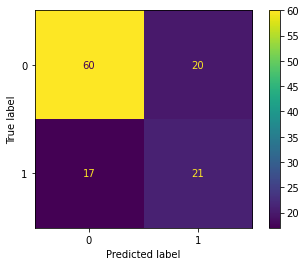

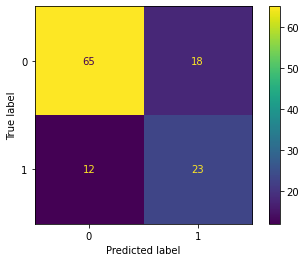

In [580]:
widget_matriz_confusion_segun_media = ConfusionMatrixDisplay(
    confusion_matrix=matriz_confusion_segun_media,
    display_labels=arbol_segun_media.classes_
    )
widget_matriz_confusion_segun_cuantiles = ConfusionMatrixDisplay(
    confusion_matrix=matriz_confusion_segun_cuantiles,
    display_labels=arbol_segun_cuantiles.classes_
    )
widget_matriz_confusion_segun_media.plot()
widget_matriz_confusion_segun_cuantiles.plot()
plt.show()

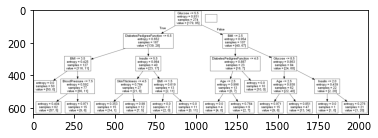

In [581]:
from matplotlib import image as pltimg
from matplotlib import pyplot as plt
import pydotplus
from datetime import datetime

def exportarAImagen(arbol, criterio):
    def generarNombreArchivo(criterio):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename=f'output\ejercicio1-segun_{criterio}_{timestamp}.png'
        return filename    
    ruta_imagen = generarNombreArchivo(criterio)
    
    data = tree.export_graphviz(arbol, feature_names=caracteristicas_entrada,out_file=None)
    graph = pydotplus.graph_from_dot_data(data)
    graph.write_png(ruta_imagen)
    
    return ruta_imagen

ruta_img_segun_media = exportarAImagen(arbol_segun_media, 'media')
ruta_img_segun_cuantiles = exportarAImagen(arbol_segun_cuantiles, 'cuantiles')

# img_media = pltimg.imread(ruta_img_segun_media)
# imgplot = plt.imshow(img_media)

img_cuantiles = pltimg.imread(ruta_img_segun_cuantiles)
imgplot_cuantiles = plt.imshow(img_cuantiles)
plt.show()

## Referencias

1. <https://www.markdownguide.org/basic-syntax/>

2. <https://scikit-learn.org/stable/modules/tree.html>

3. <https://pandas.pydata.org/docs/user_guide/index.html>
